<a href="https://colab.research.google.com/github/aimaaaaan/Attempted-Implementations-/blob/main/VLAttack_(CLIP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!unrar x "/content/drive/MyDrive/VLAttack/New.rar" .



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/VLAttack/New.rar

Extracting  ./test_224.npz                                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24%  OK 
Extracting  ./train_224.npz                                               25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 8

In [ ]:
!git clone https://github.com/ericyinyzy/VLAttack.git
%cd VLAttack/CLIP_attack

Cloning into 'VLAttack'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (759/759), done.
remote: Compressing objects: 100% (616/616), done.
remote: Total 759 (delta 131), reused 642 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (759/759), 22.21 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/VLAttack/CLIP_attack


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!pip install torch torchvision torchaudio

import torch
import clip
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rxuduxw1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rxuduxw1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=07ecb8f1201fa39c493b8833cc3f0f6916a33777acb84f204450316721ecde41
  Stored in directory: /tmp/pip-ephem-wheel-cache-_kcldlxq/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
PyTorch version: 2.8.0+cu126
CUDA available: True


Displaying first 10 images from array 'x'


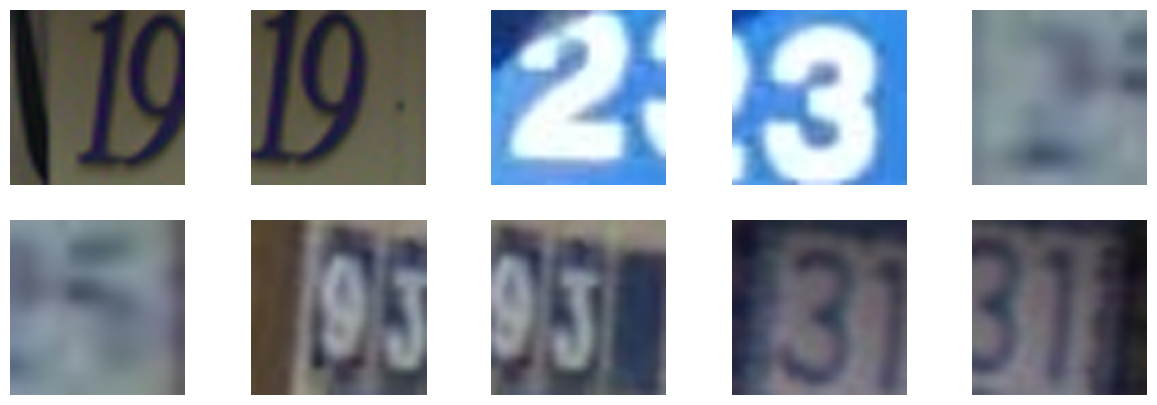

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('/content/train_224.npz')

for array_name in data.files:
    images = data[array_name]
    print(f"Displaying first 10 images from array '{array_name}'")

    #first 10 images
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()
    break


In [ ]:
train_path = '/content/train_224.npz'
test_path = '/content/test_224.npz'

***Finetuning CLIP***

In [ ]:
import torch
import torch.nn as nn
import clip
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import os, gc

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

# Paths
train_path = '/content/train_224.npz'
test_path = '/content/test_224.npz'
os.makedirs('/content/clip_model', exist_ok=True)

# Data
class LazyNPZDataset(Dataset):
    def __init__(self, npz_path, transform=None):
        arr = np.load(npz_path, mmap_mode='r')
        self.x, self.y = arr['x'], arr['y'][:,0]
        self.transform = transform
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        img = Image.fromarray(self.x[idx])
        y = int(self.y[idx])
        if self.transform: img = self.transform(img)
        return img, y

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
train_ds = LazyNPZDataset(train_path, transform)
test_ds  = LazyNPZDataset(test_path, transform)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, _ = clip.load('RN50', device=device)

# gradients for CLIP vision encoder
for name, p in clip_model.visual.named_parameters():
    p.requires_grad = True  # False to freeze, True to train (for full fine-tune)
clip_model = clip_model.to(device)

# output dim (1024 for RN50)
embed_dim = clip_model.visual.output_dim if hasattr(clip_model.visual, "output_dim") else 1024
num_classes = 10
head = ClassificationHead(embed_dim, num_classes).to(device)

# model for classification
class ClipClassifier(nn.Module):
    def __init__(self, clip_model, head):
        super().__init__()
        self.clip_model = clip_model
        self.head = head
    def forward(self, x):
        features = self.clip_model.encode_image(x)
        return self.head(features)

model = ClipClassifier(clip_model, head).to(device)

# Criterion and optimizer (train only head or whole model as needed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(list(model.parameters()), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Avg train loss: {running_loss/len(train_loader):.4f}")
    scheduler.step()

    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
    accuracy = 100 * correct / len(test_ds)
    print(f"Test accuracy after epoch {epoch+1}: {accuracy:.2f}%")
    torch.save(model.state_dict(), "/content/clip_model/finetuned_svhn_RN50.pth")
    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
# Fine-tune CLIP with RN50
#!python clip_finetune_colab.py --train_path /content/train_224.npz --test_path /content/test_224.npz --model RN50

# Fine-tune CLIP with ViT-B/16
!python clip_finetune_colab.py --train_path /content/train_224.npz --test_path /content/test_224.npz --model ViT-B/16


100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 62.2MiB/s]
Model loaded successfully
^C


***Attack script***

In [ ]:
%%writefile clip_attack_colab.py
import clip
import argparse
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from PIL import Image
import copy
import os
import sys

sys.path.append('/content/VLAttack/cleverhans')

test_transform_CLIP = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class SVHNCUSTOM(Dataset):
    def __init__(self, numpy_file, class_type, transform=None):
        self.input_array = np.load(numpy_file)
        self.data = self.input_array['x']
        self.targets = self.input_array['y'][:,0].tolist()
        self.classes = class_type
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

class SVHN10Mem(SVHNCUSTOM):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return index, img, target

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

def find_clip_right(test_loader, black_model, max_samples=5000):
    correct = 0
    correct_index = []
    with torch.no_grad():
        for index, images, labels in test_loader:
            images, labels = images.cuda(non_blocking=True), labels.cuda(non_blocking=True)
            logits, _ = black_model(images)
            pred = logits.argmax(dim=1, keepdim=True)
            success = pred.eq(labels.view_as(pred)).sum().item()
            if success == 1:
                correct_index.append(str(index.item()))
            if len(correct_index) == max_samples:
                break
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_acc = 100. * correct / len(correct_index) if len(correct_index) > 0 else 0
    print(f'Test accuracy: {test_acc:.2f}%')
    print(f'Found {len(correct_index)} correctly predicted samples')
    return correct_index

def pgd_attack(x, white_model):
    _, feats_list = white_model(x)
    return [feats_list]

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--test_path', default='/content/test_224.npz')
    parser.add_argument('--model', default='RN50')
    parser.add_argument('--method', default='BSA')
    args = parser.parse_args()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    test_data_clean = SVHN10Mem(numpy_file=args.test_path, class_type=classes,
                                 transform=test_transform_CLIP)
    test_loader = DataLoader(test_data_clean, batch_size=1, shuffle=False,
                            num_workers=2, pin_memory=True)

    if args.model == 'RN50':
        model, preprocess = clip.load("RN50", device=device)
        model_path = "/content/clip_model/finetuned_svhn_RN50.pth"
        print('Load RN50 success!')
    elif args.model == 'ViT-B/16':
        model, preprocess = clip.load("ViT-B/16", device=device)
        model_path = "/content/clip_model/finetuned_svhn_ViTB16.pth"
        print('Load ViT-B/16 success!')
    else:
        print('only support RN50 and ViTB/16 now!')
        raise ValueError

    if args.method == 'BSA' or args.method == 'SSP' or args.method == 'DR':
        import cleverhans.torch.attacks.CLIP.projected_gradient_descent as pgd
    elif args.method == 'FDA':
        import cleverhans.torch.attacks.CLIP.projected_gradient_descent_FDA as pgd
    else:
        print('attack method is not supported!')
        raise ValueError

    white_model = copy.deepcopy(model)
    model.load_state_dict(torch.load(model_path))
    black_model = model
    black_model.eval()
    model = model.to(device)

    clip_right_list = find_clip_right(test_loader, black_model)

    cnt = 0
    correct = 0

    with torch.no_grad():
        for index, images, labels in tqdm(test_loader):
            if str(index.item()) in clip_right_list:
                cnt += 1
                images, labels = images.cuda(non_blocking=True), labels.cuda(non_blocking=True)
                _, feats_list = white_model(images)
                adv_img = copy.deepcopy(images)

                torch.set_grad_enabled(True)
                adv_x, _ = pgd.projected_gradient_descent(
                    lambda x: pgd_attack(x, white_model),
                    adv_img,
                    0.125, 0.01, 40, np.inf,
                    clip_min=-1, clip_max=1,
                    y=[feats_list],
                    time=0,
                    ori_x=images,
                    method=args.method,
                    model=args.model
                )
                torch.set_grad_enabled(False)

                logits, _ = black_model(adv_x)
                pred = logits.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

                if cnt % 100 == 0:
                    print(f'Processed {cnt} samples, Attack Success Rate: {1 - correct / cnt:.4f}')

    final_asr = 1 - correct / cnt if cnt > 0 else 0
    print(f'Final Attack Success Rate: {final_asr:.4f}')


Writing clip_attack_colab.py


In [ ]:
# BSA attack on CLIP
!python clip_attack_colab.py --test_path /content/test_224.npz --model ViT-B/16 --method BSA

# other methods
# !python clip_attack_colab.py --test_path /content/test_224.npz --model RN50 --method DR
# !python clip_attack_colab.py --test_path /content/test_224.npz --model RN50 --method FDA
# !python clip_attack_colab.py --test_path /content/test_224.npz --model RN50 --method SSP


Load ViT-B/16 success!
Traceback (most recent call last):
  File "/content/clip_attack_colab.py", line 100, in <module>
    model.load_state_dict(torch.load(model_path))
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1484, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 759, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 740, in __init__
    super().__init__(open(name, mode))
                     ^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/clip_model/finetuned_svhn_ViTB16.pth'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import clip
from PIL import Image

def visualize_attack(original_img, adversarial_img, original_pred, adv_pred, original_label):
    """Visualize original vs adversarial images"""

    # Denormalize images
    def denorm(img):
        img = img * 0.5 + 0.5
        return np.clip(img, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    orig_np = denorm(original_img.cpu().numpy().transpose(1, 2, 0))
    axes[0].imshow(orig_np)
    axes[0].set_title(f'Original\nTrue: {original_label}, Pred: {original_pred}')
    axes[0].axis('off')

    # Adversarial image
    adv_np = denorm(adversarial_img.cpu().numpy().transpose(1, 2, 0))
    axes[1].imshow(adv_np)
    axes[1].set_title(f'Adversarial\nTrue: {original_label}, Pred: {adv_pred}')
    axes[1].axis('off')

    # Perturbation
    perturbation = adversarial_img - original_img
    pert_np = denorm(perturbation.cpu().numpy().transpose(1, 2, 0) * 10)
    axes[2].imshow(pert_np)
    axes[2].set_title(f'Perturbation (10x)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# Save attack results
import json

results = {
    'model': 'RN50',
    'method': 'BSA',
    'attack_success_rate': final_asr,
    'num_samples': cnt,
    'parameters': {
        'epsilon': 0.125,
        'step_size': 0.01,
        'iterations': 40,
        'norm': 'L_inf'
    }
}

with open('/content/drive/MyDrive/VLAttack/attack_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Results saved to Google Drive!")


In [ ]:
#cd /content/VLAttack/CLIP_attack

In [ ]:
#!ls


In [ ]:
#python /content/VLAttack/CLIP_attack/clip_finetune.py --model RN50 --train_path /content/train_224.npz --test_path /content/test_224.npz